# Quantum Energy Solver

1 Dimension에 대해 Finite differnce scheme으로 basis를 구성 하고, 그 위에서 최종 inhomogeneous K dot P 계산 까지

우선, 필요한 모듈을 불러오기 (import)

numpy : 수학 및 array 관련 모듈

matplotlib : 그래프 그리는 모듈

scipy : 다양한 과학에 응용되는 수학 모듈

scipy.sparse : scipy 중 sparse matrix에 관련된 모듈

In [58]:
%matplotlib inline
import numpy as np ### 수학 모듈 (numpy)를 불러와 np로 호출
import matplotlib.pyplot as plt   ### 그래프 그리는 모듈 matplot.pyplot을 불러와 plt로 호출
from scipy.sparse import csr_matrix, eye, diags   ### sparse matrix  메모리 줄임
from scipy.sparse.linalg import eigs, spsolve

<img src = 'https://www.computerhope.com/jargon/s/sparse-matrix-example.jpg'>

### Parameter 정의

In [59]:
boundary = 'Dirichlet'  # or 'Neumann'
hbar = 6.626e-34/2/np.pi
e = 1.6e-19
eo = 8.85e-12
er = 9
emass = 9.1e-31
me = 0.13   # CdSe me=0.13 mh=0.45       # CdS me:0.21 mh:0.8
mh = 0.45   # CdTe me=0.1  mh=0.4
Ep=20                     # CdS: me.18 mh0.6 Eg2.45       VBO=0.52    qX=4.79 er=8.6

### Define geometry (mesh)에 따른 각 parameter 입력

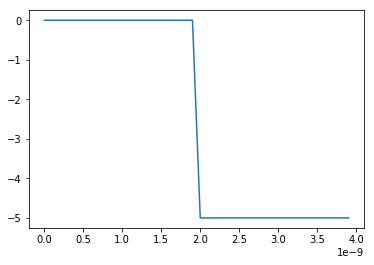

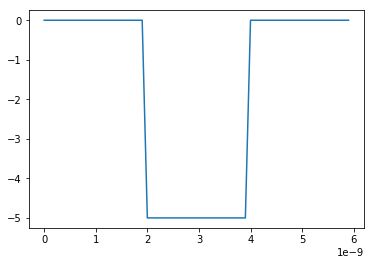

In [60]:
spacing = 1e-10   # mesh size
CB = np.append(np.zeros(20), np.ones(20)*-5)   # np.zeros(숫자))  : 숫자갯수만큼의 array 생성
plt.plot(np.arange(len(CB))*spacing, CB)   # arange(처음 수, 끝 수, 스텝)


# 새로운 그림 
CB = np.append(CB, np.zeros(20))     # append : 2개의 array들을 이음
plt.figure()                         # 새 그림 그릴때 필요
X = np.arange(0, len(CB)*spacing, spacing)   # X 축 정의
n = X.size                           # n은 전체 mesh 갯수가 됨
plt.plot(np.arange(len(CB))*spacing, CB)   # plt.plot(x축, y축)


## Solve Schrodinger Equation

$$ \biggl(-\frac{\nabla^2}{2m} + V\biggr)\psi = E\psi $$

### Kinetic energy

$$ \biggl(-\frac{\nabla^2}{2m} \biggr) $$

matrix([[ 58.7541299 , -58.7541299 ,   0.        ,   0.        ,
           0.        ],
        [-29.37706495,  58.7541299 , -29.37706495,   0.        ,
           0.        ],
        [  0.        , -29.37706495,  58.7541299 , -29.37706495,
           0.        ],
        [  0.        ,   0.        , -29.37706495,  58.7541299 ,
         -29.37706495],
        [  0.        ,   0.        ,   0.        , -29.37706495,
          58.7541299 ]])

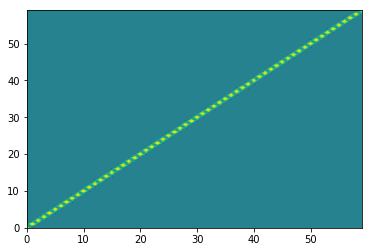

In [61]:
laplace = eye(n)*(-2) +eye(n,k=1) +eye(n, k=-1)   # eye : unitary matrix
#if boundary == 'Neumann':
laplace[-1,-2] *= 2                               # numpy index 공부할것 
laplace[0,1] *= 2
laplace *= (-0.5 * (hbar**2)) 
laplace /= (me*emass*e*spacing**2)
plt.contourf(laplace.todense())
laplace.todense()[:5,:5]              # .todense() sparse matrix를 dense matrix로 변환, 여기서는 결과 확인용

### Potential energy (V)

In [62]:
V = diags(CB)     # CB의 array를 diagonal 성분으로 갖는 sparse matrix 생성
V.todense()[15:25, 15:25]

matrix([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -5.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -5.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -5.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -5.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -5.]])

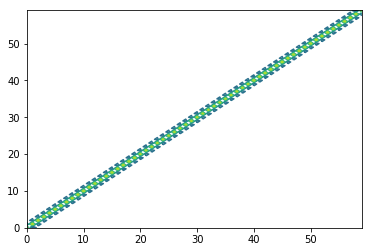

In [63]:
Hamiltonian = csr_matrix(laplace + V)   # sparse matrix 한 종류
plt.contour(Hamiltonian.todense())

### Solve Hamiltonian

[-4.53744597+0.j -3.19310382+0.j -1.16095307+0.j  0.12955255+0.j
  0.21552803+0.j]
[1.34434215+0.j 2.03215075+0.j 1.29050562+0.j 0.08597548+0.j]


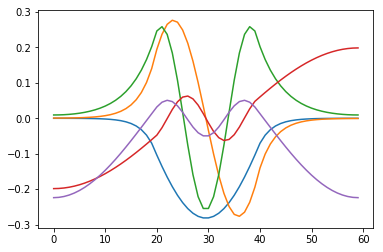

In [64]:
eev, eef= eigs(Hamiltonian, 5, sigma = -5, which='LM')  
# Linear algebra solution, 5개 해를, -5 근처에서, 'LM' : least magnitude 순으로
plt.plot(eef)
print (eev)
print (np.diff(eev))

### Normalization of wavefunction

In [65]:
print (np.sum(eef[:,0]*np.conjugate(eef[:,0]))*spacing)

(9.999999999999999e-11+0j)


It's not normalized~!!

Let's normalize so that 

$$ \int \phi\phi^* dz = 1 $$

for this

$$ \phi = \frac{\phi}  {(\sqrt{\int \phi\phi^* })}$$

In [66]:
def normalization(wf):
    norm = np.sqrt(np.sum(wf*np.conjugate(wf))*spacing)
    wf /= norm
    return wf

In [67]:
e_norm = normalization(eef[:,0])
print (np.sum(e_norm*np.conjugate(e_norm))*spacing)

(1.0000000000000002+0j)


Now, it's normalized

# Simple Harmonic Oscillator

Equal energy differences between energies

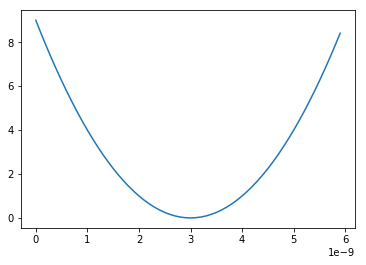

In [68]:
CB = 1e18*(X-3e-9)**2
plt.plot(X, CB)

[0.54137975+0.j 1.62286789+0.j 2.70162336+0.j 3.77619059+0.j
 4.83971161+0.j]
[1.08148814+0.j 1.07875547+0.j 1.07456723+0.j 1.06352102+0.j]


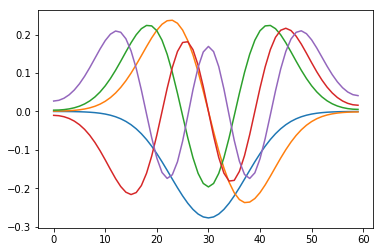

In [69]:
V = diags(CB)
V.todense()[15:25, 15:25]
Hamiltonian = csr_matrix(laplace + V)
eev, eef= eigs(Hamiltonian, 5, sigma = 0, which='LM')
plt.plot(eef)
print (eev)
print (np.diff(eev))

## Mimic of Hydrogen atom

/Users/KP/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


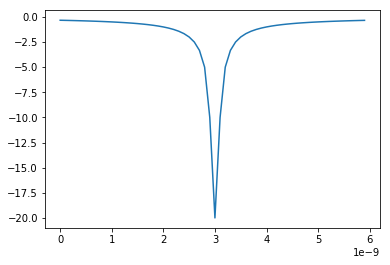

In [70]:
CB = -1e-9*(1/np.abs((X-3e-9)))
CB[30] = -20   # to prevent the divergence
plt.plot(X, CB)

[-8.20524828+0.j -0.85123072+0.j -0.50509639+0.j -0.19808648+0.j
  0.09283391+0.j]
[7.35401755+0.j 0.34613433+0.j 0.30700991+0.j 0.29092038+0.j]


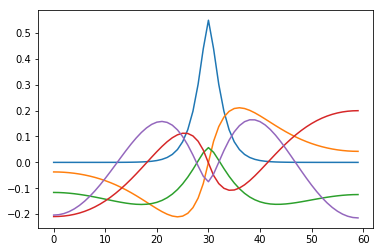

In [71]:
V = diags(CB)
V.todense()[15:25, 15:25]
Hamiltonian = csr_matrix(laplace + V)
eev, eef= eigs(Hamiltonian, 5, sigma = -40, which='LM')
plt.plot(eef)
print (eev)
print (np.diff(eev))

## Asymmetric well for Type-II QDs

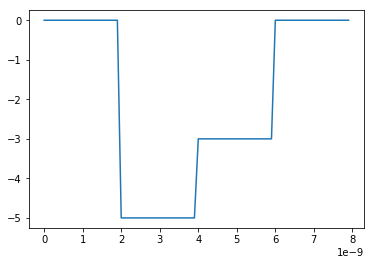

In [72]:
spacing = 1e-10
CB = np.append(np.zeros(20), np.ones(20)*-5)   # np.zeros(숫자))  : 숫자갯수만큼의 array 생성
CB = np.append(CB, np.ones(20)*-3)     # append : 2개의 array들을 이음
CB = np.append(CB, np.zeros(20))
X = np.arange(0, len(CB)*spacing, spacing)   # X 축 정의
n = X.size                           # n은 전체 mesh 갯수가 됨
plt.plot(np.arange(len(CB))*spacing, CB)   # plt.plot(x축, y축)


[-4.58794018+0.j]


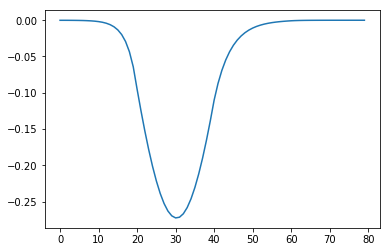

In [73]:
laplace = eye(n)*(-2) +eye(n,k=1) +eye(n, k=-1)   # eye : unitary matrix
laplace[-1,-2] *= 2                               # numpy index 공부할것 
laplace[0,1] *= 2
laplace *= (-0.5 * (hbar**2)) 
laplace /= (me*emass*e*spacing**2)
V = diags(CB)     # CB의 array를 diagonal 성분으로 갖는 sparse matrix 생성
Hamiltonian = csr_matrix(laplace + V)
eev, eef= eigs(Hamiltonian, 1, sigma = -5, which='LM')
plt.plot(eef)
print (eev)

## K dot P

And calculate both electron and hole simultaneously

$$\begin{pmatrix} electron & KP \\\ KP & hole \end{pmatrix}$$

$$ KP =\frac{\hbar}{m} K \cdot p $$

momentum operator $ p = -i\hbar \nabla $


In [74]:
me = 0.13
mh = 0.45

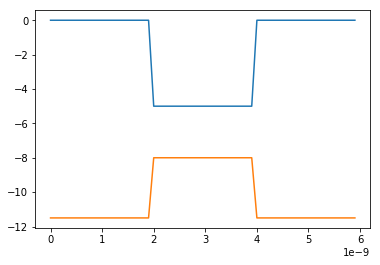

In [75]:
spacing = 1e-10
Eg = 1.5
CB = np.append(np.zeros(20), np.ones(20)*-5)   # np.zeros(숫자))  : 숫자갯수만큼의 array 생성
CB = np.append(CB, np.zeros(20))     # append : 2개의 array들을 이음
X = np.arange(0, len(CB)*spacing, spacing)   # X 축 정의
n = X.size                           # n은 전체 mesh 갯수가 됨

VB = np.append(np.ones(20)*10, np.ones(20)*6.5)   # np.zeros(숫자))  : 숫자갯수만큼의 array 생성
VB = np.append(VB, np.ones(20)*10)     # append : 2개의 array들을 이음

plt.plot(np.arange(len(CB))*spacing, CB)   # plt.plot(x축, y축)
plt.plot(np.arange(len(CB))*spacing, -Eg-VB)
CB = diags(CB)
VB = diags(VB)

In [76]:
def laplace(n, coefficient, boundary = 'Dirichlet', Coulomb = False):
    mat = eye(n)*(-2) +eye(n,k=1) +eye(n, k=-1)   # eye : unitary matrix
    if boundary == 'Neumann':
        mat[-1,-2] *= 2                               # numpy index 공부할것 
        mat[0,1] *= 2
    if Coulomb == False:
        mat *= (-0.5 * (hbar**2)) 
        mat /= (coefficient*emass*e)
    else:
        mat *= (coefficient)
    mat /= (spacing**2)
    return mat

In [77]:
laplaceCB = laplace(n, me, )
laplaceVB = laplace(n, mh, )

In [78]:
off_diagonal = eye(n, k = 1) - eye(n, k = -1)* -1
off_diagonal = off_diagonal * (-1j*hbar*np.sqrt(Ep/2)) / spacing

In [79]:
kp = np.zeros((2*n, 2*n), dtype = complex)
kp[:n, :n] = (laplaceCB + CB).todense()
kp[n:2*n, n: 2*n] = -1*(laplaceVB + VB).todense()
kp[:n, n:2*n] = off_diagonal.todense()
kp[n:2*n, :n] = off_diagonal.todense()
kp = csr_matrix(kp)

In [80]:
eev, eef= eigs(kp, 1, sigma = -5, which='LM')
hev, hef= eigs(kp, 1, sigma = -6.5 , which='LM')

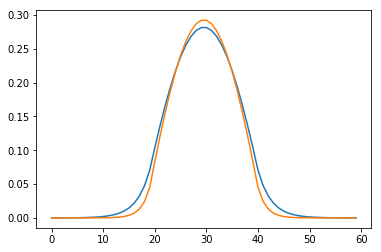

In [81]:
plt.plot(np.abs(eef[:n]))
plt.plot(np.abs(hef[n:]))

## Type-II QD with K dot P

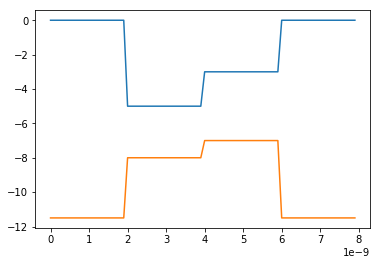

In [82]:
spacing = 1e-10
Eg = 1.5
CB = np.append(np.zeros(20), np.ones(20)*-5)   # np.zeros(숫자))  : 숫자갯수만큼의 array 생성
CB = np.append(CB, np.ones(20)*-3)     # append : 2개의 array들을 이음
CB = np.append(CB, np.zeros(20))
X = np.arange(0, len(CB)*spacing, spacing)   # X 축 정의
n = X.size                           # n은 전체 mesh 갯수가 됨

VB = np.append(np.ones(20)*10, np.ones(20)*6.5)   # np.zeros(숫자))  : 숫자갯수만큼의 array 생성
VB = np.append(VB, np.ones(20)*5.5)     # append : 2개의 array들을 이음
VB = np.append(VB, np.ones(20)*10)
plt.plot(np.arange(len(CB))*spacing, CB)   # plt.plot(x축, y축)
plt.plot(np.arange(len(CB))*spacing, -Eg-VB)

CB = diags(CB)
VB = diags(VB)

Don't want to repeat the same code again, so let's make Function (def) 

In [83]:
def off_diagonal_matrix(n):
    off_diagonal = eye(n, k = 1) - eye(n, k = -1)* -1
    off_diagonal = off_diagonal * (-1j*hbar*np.sqrt(Ep/2)) / spacing
    return off_diagonal

def kp_matrix(mat1, mat2, mat_off):
    kp = np.zeros((2*n, 2*n), dtype = complex)
    kp[:n, :n] = (mat1 + CB).todense()
    kp[n:2*n, n: 2*n] = -1*(mat2 + VB).todense()
    kp[:n, n:2*n] = mat_off.todense()
    kp[n:2*n, :n] = mat_off.todense()
    kp = csr_matrix(kp)
    return kp

In [84]:
laplaceCB = laplace(n, me) 
laplaceVB = laplace(n, mh)
off_diagonal = off_diagonal_matrix(n)

In [85]:
kp = kp_matrix(laplaceCB, laplaceVB, off_diagonal)

Text(0.5, 1.0, 'Wavefunctions')

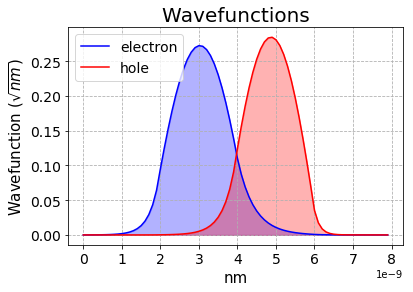

In [86]:
eev, eef= eigs(kp, 1, sigma = -5, which='LM')
hev, hef= eigs(kp, 1, sigma = -5.5 , which='LM')

plt.plot(X, np.abs(eef[:n]), 'b', label = 'electron')
plt.plot(X, np.abs(hef[n:]), 'r', label = 'hole')
plt.fill_between(X, 0, np.abs(eef[:n])[:,0], alpha = 0.3, color = 'b')
plt.fill_between(X, 0, np.abs(hef[n:])[:,0], alpha = 0.3, color = 'r')
plt.legend(fontsize = 14, loc = 2)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('nm', fontsize = 15)
plt.ylabel('Wavefunction ($\sqrt{nm}$)', fontsize = 15)
plt.grid(linestyle = '--')
plt.title('Wavefunctions', fontsize = 20)

In [87]:
eef_norm = normalization(eef[:n,0])
hef_norm = normalization(hef[n:,0])
overlap_integral = np.abs(np.sum(np.multiply(eef_norm, np.conjugate(hef_norm))*spacing))
print ('Overlap integral : {:.3f}'.format(overlap_integral))

Overlap integral : 0.167


## Poisson equation

In [88]:
def laplace(n, coefficient, boundary = 'Dirichlet', Coulomb = False):
    mat = eye(n)*(-2) +eye(n,k=1) +eye(n, k=-1)   # eye : unitary matrix
    if boundary == 'Neumann':
        mat[-1,-2] *= 2                               # numpy index 공부할것 
        mat[0,1] *= 2
    if Coulomb == False:
        mat *= (-0.5 * (hbar**2)) 
        mat /= (coefficient*emass*e)
    elif Coulomb == True:
        mat *= (coefficient)
    mat /= (spacing**2)
    return mat

In [89]:
eef_square = np.abs(eef_norm)**2
hef_square = np.abs(hef_norm)**2
er1 = 9
laplace_coulomb = laplace(n, er1, 'Neumann', Coulomb = 'True')

vce = spsolve(laplace_coulomb, eef_square*e/eo)
vch = spsolve(laplace_coulomb, hef_square*e/eo)

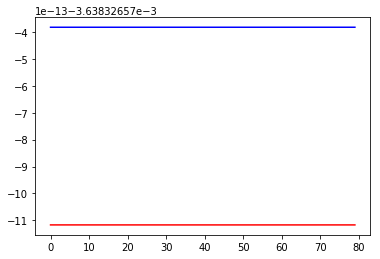

In [90]:
plt.plot(vce, 'b')
plt.plot(vch, 'r')

In [91]:
vce

array([-0.00363833, -0.00363833, -0.00363833, -0.00363833, -0.00363833,
       -0.00363833, -0.00363833, -0.00363833, -0.00363833, -0.00363833,
       -0.00363833, -0.00363833, -0.00363833, -0.00363833, -0.00363833,
       -0.00363833, -0.00363833, -0.00363833, -0.00363833, -0.00363833,
       -0.00363833, -0.00363833, -0.00363833, -0.00363833, -0.00363833,
       -0.00363833, -0.00363833, -0.00363833, -0.00363833, -0.00363833,
       -0.00363833, -0.00363833, -0.00363833, -0.00363833, -0.00363833,
       -0.00363833, -0.00363833, -0.00363833, -0.00363833, -0.00363833,
       -0.00363833, -0.00363833, -0.00363833, -0.00363833, -0.00363833,
       -0.00363833, -0.00363833, -0.00363833, -0.00363833, -0.00363833,
       -0.00363833, -0.00363833, -0.00363833, -0.00363833, -0.00363833,
       -0.00363833, -0.00363833, -0.00363833, -0.00363833, -0.00363833,
       -0.00363833, -0.00363833, -0.00363833, -0.00363833, -0.00363833,
       -0.00363833, -0.00363833, -0.00363833, -0.00363833, -0.00

## Inhomogeneous medium

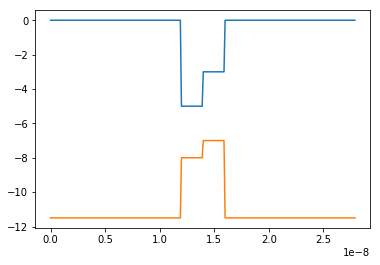

In [92]:
spacing = 1e-10
Eg = 1.5
CB = np.append(np.zeros(120), np.ones(20)*-5)   # np.zeros(숫자))  : 숫자갯수만큼의 array 생성
CB = np.append(CB, np.ones(20)*-3)     # append : 2개의 array들을 이음
CB = np.append(CB, np.zeros(120))
X = np.arange(0, len(CB)*spacing, spacing)   # X 축 정의
n = X.size                           # n은 전체 mesh 갯수가 됨

VB = np.append(np.ones(120)*10, np.ones(20)*6.5)   # np.zeros(숫자))  : 숫자갯수만큼의 array 생성
VB = np.append(VB, np.ones(20)*5.5)     # append : 2개의 array들을 이음
VB = np.append(VB, np.ones(120)*10)
plt.plot(np.arange(len(CB))*spacing, CB)   # plt.plot(x축, y축)
plt.plot(np.arange(len(CB))*spacing, -Eg-VB)

In [93]:
CB = diags(CB)
VB = diags(VB)

In [94]:
me1 = 0.13   # CdSe me=0.13 mh=0.45       # CdS me:0.21 mh:0.8
mh1 = 0.45   # CdTe me=0.1  mh=0.4
me2 = 0.16
mh2 = 0.57
er1 = 9
er2 = 10
me = np.ones(280, dtype = float)*0.1
mh = np.ones(280, dtype = float)*0.4
er = np.ones(280, dtype = float)*1
me[120:140] = me1
me[140:160] = me2
mh[120:140] = mh1
mh[140:160] = mh2
er[120:140] = er1
er[140:160] = er1
er[120:140] = er1
er[140:160] = er1

In [95]:
def inhomo_laplace(n, coeff, boundary = 'Dirichlet', Coulomb = False):
    mat = -(eye(n)*diags((np.roll(coeff,1)+np.roll(coeff,-1)))) + eye(n, k = 1)*diags(np.roll(coeff, -1)) \
    + eye(n, k = -1)*diags(np.roll(coeff, 1))
    if boundary == 'Neumann':
        mat[-1,-2] *= 2                               # numpy index 공부할것 
        mat[0,1] *= 2
    if Coulomb == False:
        mat *= (-0.5 * (hbar**2)) 
        mat /= (emass*e)  
    
    mat /= (spacing**2)
    mat = csr_matrix(mat)
    return mat

In [96]:
laplaceCB = inhomo_laplace(n, me)
laplaceVB = inhomo_laplace(n, mh)

In [97]:
off_diagonal = off_diagonal_matrix(n)
kp = kp_matrix(laplaceCB, laplaceVB, off_diagonal)

In [98]:
eev, eef= eigs(kp, 1, sigma = -5, which='LM')
hev, hef= eigs(kp, 1, sigma = -5.5 , which='LM')

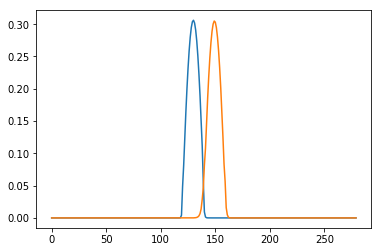

In [99]:
plt.plot(np.abs(eef[:n]))
plt.plot(np.abs(hef[n:]))

In [100]:
eef_norm = normalization(eef[:n,0])
hef_norm = normalization(hef[n:,0])
overlap_integral = np.abs(np.sum(np.multiply(eef_norm, np.conjugate(hef_norm))*spacing))
print ('Overlap integral : {:.3f}'.format(overlap_integral))

Overlap integral : 0.012


## Dielectric confinement

Have a look

Movilla, 'Dielectric confinement in quantum dots of arbitrary shape within the local spin density approximation: Diluted regimes in elongated quantum dots'

and

'Dielectric polarization in axially-symmetric nanostructures: A computational
approach'

In [108]:
boundary = 'Neumann'
boundary = 'Dirichlet'
eef_square = np.abs(eef_norm)**2
hef_square = np.abs(hef_norm)**2

inhomo_coulomb = inhomo_laplace(n, 1/er, boundary, Coulomb = 'True')

vce = spsolve(inhomo_coulomb, eef_square * e/ eo)
vch = spsolve(inhomo_coulomb, hef_square * e/ eo)

In [109]:
homo_coulomb = laplace(n, 1, boundary, Coulomb = 'True')

vce_homo = spsolve(homo_coulomb, eef_square * e/ eo)
vch_homo = spsolve(homo_coulomb, hef_square * e/ eo)

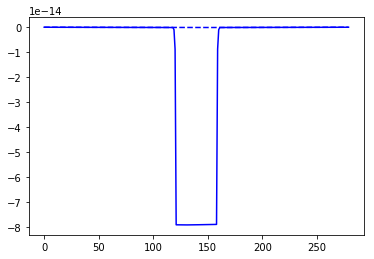

In [110]:
plt.plot(vce, 'b')
plt.plot(vce_homo, 'b--')
#plt.plot(vch, 'r')

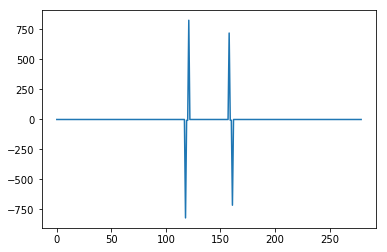

In [111]:
a = -inhomo_coulomb*vce_homo/4/np.pi
plt.plot(a)#+np.multiply((er-1), eefsuqre)

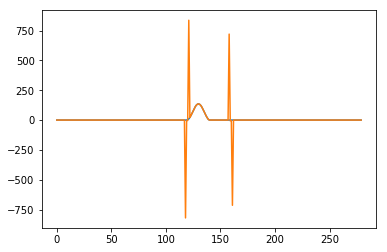

In [112]:
b = np.multiply((er-1), eef_square*e/eo)
plt.plot(b)
plt.plot(b+a)

In [113]:
total = (inhomo_coulomb+ np.multiply(homo_coulomb.todense(), er))/4/np.pi
vci = spsolve(total, (b+a))

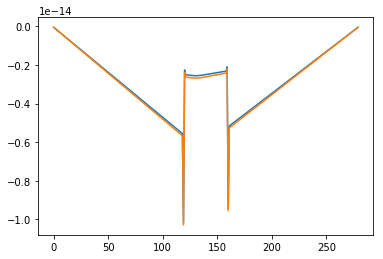

In [115]:
#plt.plot(vce_homo)
plt.plot(vci)
plt.plot(vce_homo+vci)
#plt.xlim([110, 180])